## Importing Required Libararies

In [9]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt

## Constructing Graph with given dataset

In [2]:
df = pd.read_csv('Payments.csv')

# Construct Graph
def construct_graph(data):
    G = nx.MultiDiGraph()
    for index, row in data.iterrows():
        G.add_weighted_edges_from([(row['Sender'], row['Receiver'], row['Amount'])])
    return G

myGraph = construct_graph(df)

### Lableling nodes for feature vector computation

In [3]:
set1 = set(df['Sender'].unique())
set2 = set(df['Receiver'].unique())
mySet = set1.union(set2)
myList = list(mySet)
myList.sort()

myLabels = {}
for i in range(799):
    myLabels[myList[i]] = i


## Preparing data for GCN model

In [6]:
# Convert the graph to PyTorch Geometric's data format
data = from_networkx(myGraph)

edge_features = torch.tensor([myGraph[u][v][0]['weight'] for u, v in myGraph.edges()], dtype=torch.float)

# Construct feature vector with one-hot encoding of sender/receiver
num_nodes = len(myGraph.nodes)
feature_vector_type1 = torch.zeros(num_nodes, 2)  # Assuming there are only 2 categories: sender and receiver
for i, node in enumerate(myGraph.nodes):
    if myGraph.in_degree(node) > 0:  # Receiver
        feature_vector_type1[i][1] = 1
    else:  # Sender
        feature_vector_type1[i][0] = 1

# Construct feature vector with one-hot encoding and input and ouput edge counts
feature_vector_type2 = torch.zeros(num_nodes, num_nodes)
for i, row in df.iterrows():
    feature_vector[myLabels[row['Sender']]][myLabels[row['Receiver']]] = feature_vector[myLabels[row['Sender']]][myLabels[row['Receiver']]] + 1
    feature_vector[myLabels[row['Receiver']]][myLabels[row['Sender']]] = feature_vector[myLabels[row['Receiver']]][myLabels[row['Sender']]] - 1


# Assign node features and edge features to the data object
# Try any of the above feature vectors and chose best one
data.x = feature_vector_type1
data.edge_attr = edge_features.view(-1, 1)  # Reshape edge features to be compatible with PyTorch Geometric

## Graph Embedding with GCN model

In [7]:
# Define GCN model
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        return F.log_softmax(x, dim=1)

# Initialize GCN model
model = GCN(in_channels=2, hidden_channels=64, out_channels=32)
output = model(data)
embeddings = output.detach().numpy()

## Checking Optimal Clusters count with K means inertia

/home/asus/jupyter/environment/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/asus/jupyter/environment/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/asus/jupyter/environment/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/asus/jupyter/environment/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default valu

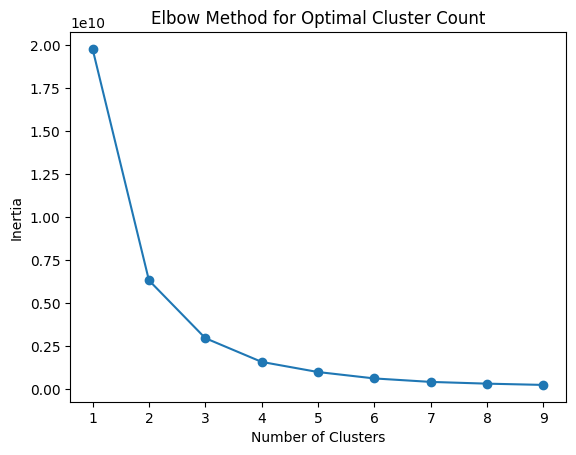

In [10]:
# Initialize a list to store inertia values
inertia_values = []

# Try different cluster counts
cluster_range = range(1, 10)  # You can adjust the range of cluster counts
for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(embeddings)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(cluster_range, inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Cluster Count')
plt.show()

## Checking Optimal Clusters count with Silhouette Scores

/home/asus/jupyter/environment/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/asus/jupyter/environment/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/asus/jupyter/environment/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/asus/jupyter/environment/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default valu

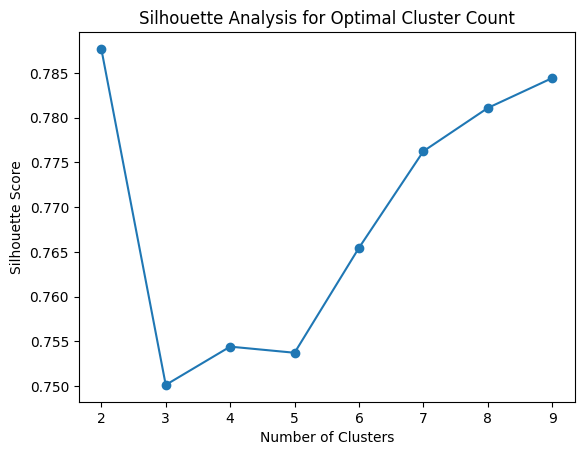

In [11]:
# Initialize a list to store silhouette scores
silhouette_scores = []

# Try different cluster counts
cluster_range = range(2, 10)  # You can adjust the range of cluster counts
for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    silhouette_scores.append(silhouette_score(embeddings, cluster_labels))

# Plot the silhouette scores
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal Cluster Count')
plt.show()

## KMeans clustering on the embedded graph nodes

/home/asus/jupyter/environment/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


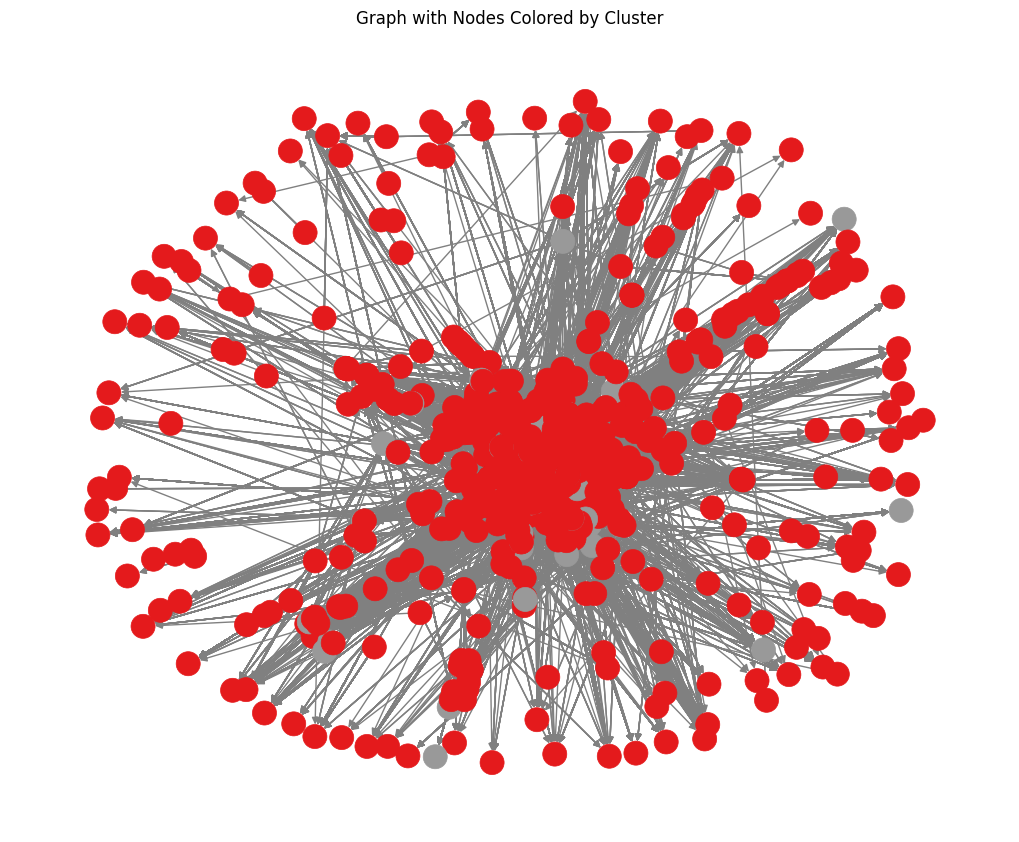

In [17]:

# Apply KMeans clustering
num_clusters = 2  # You can adjust the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings)


# Plot the graph with nodes colored by cluster
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(myGraph, seed=42)  # Position nodes using the spring layout algorithm
nx.draw(myGraph, pos, node_color=clusters, cmap=plt.cm.Set1, node_size=300, with_labels=False, edge_color='gray', linewidths=0.5)
plt.title('Graph with Nodes Colored by Cluster')
plt.show()

## DBSCAN clustering on embedded graph nodes

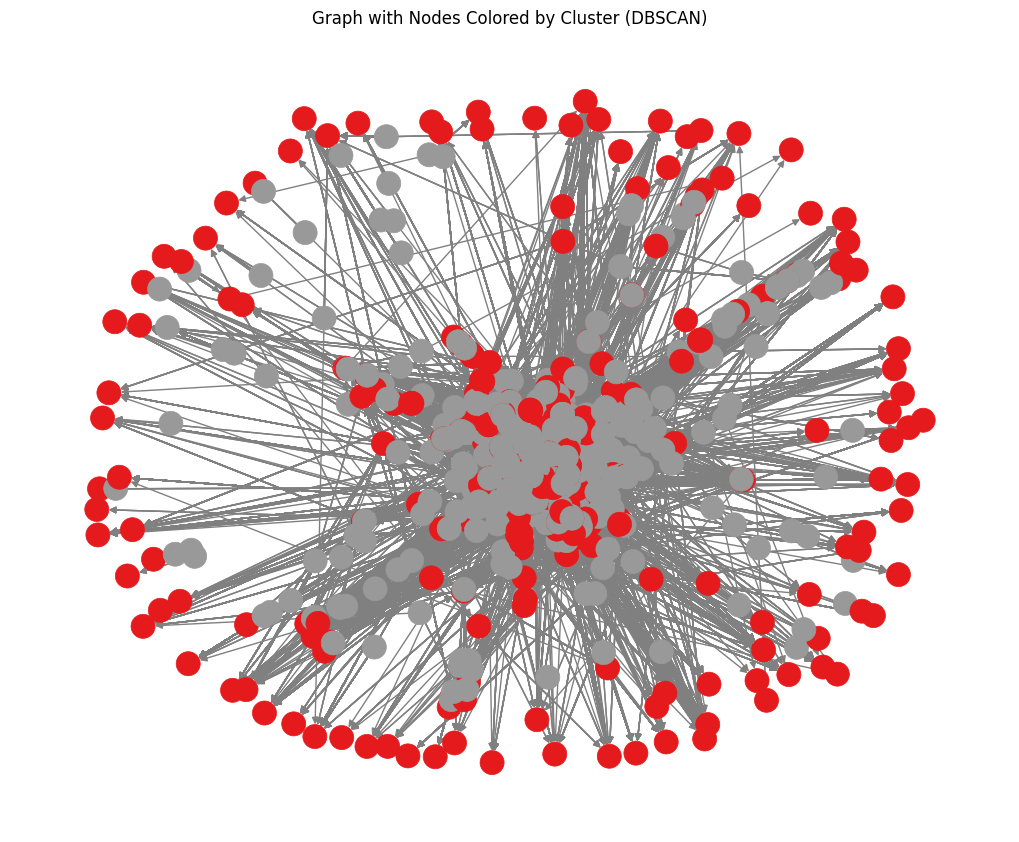

In [14]:

# Apply DBSCAN clustering
eps = 1  # The maximum distance between two samples for them to be considered as in the same neighborhood
min_samples = 5  # The number of samples in a neighborhood for a point to be considered as a core point
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(embeddings)


# Plot the graph with nodes colored by cluster
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(myGraph, seed=42)  # Position nodes using the spring layout algorithm
nx.draw(myGraph, pos, node_color=clusters, cmap=plt.cm.Set1, node_size=300, with_labels=False, edge_color='gray', linewidths=0.5)
plt.title('Graph with Nodes Colored by Cluster (DBSCAN)')
plt.show()